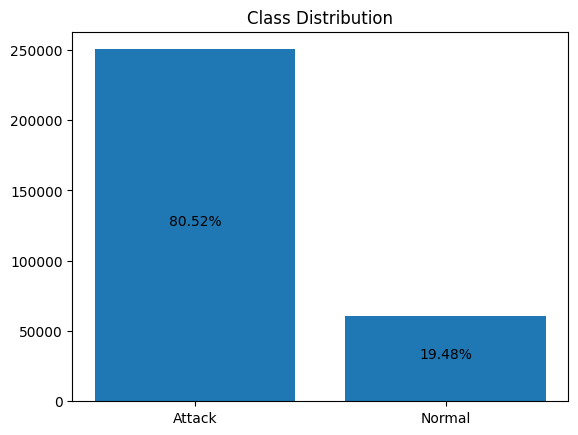

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from scipy.stats import mannwhitneyu
from pprint import pprint
from time import time
from sklearn.model_selection import cross_validate, KFold

from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
# enable experimental features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5

# Importing the dataset

path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

data.label.value_counts()

# define numerical cols
num_cols = X.drop(columns=categorical_cols).columns.tolist()

# Preprocessing pipelines for numerical and categorical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8"))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)


# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [2]:
# Function to create missing data
def cutout_data(X, pct, filler=np.nan):
    X_missing = X.copy()
    n_samples = int(len(X_missing) * pct)  # Number of samples to be missing
    pct_idx = np.random.choice(X_missing.index, n_samples, replace=False)  # Random indices
    pct_cols = np.random.choice(X_missing.columns, int(len(X_missing.columns) * 1), replace=False)  # Random columns
    X_missing.loc[pct_idx, pct_cols] = filler  # Set the selected entries to NaN
    return X_missing

X_missing10 = cutout_data(X_train, 0.1)
X_missing20 = cutout_data(X_train, 0.2)
X_missing30 = cutout_data(X_train, 0.3)
X_missing50 = cutout_data(X_train, 0.5)

# datasets
datasets = {
	'10pct': (X_missing10),
	'20pct': (X_missing20),
	'30pct': (X_missing30),
	'50pct': (X_missing50)
}

print("Missing Data in X_missing10: ", X_missing10.isna().mean().mean().round(4) * 100)
print("Missing Data in X_missing20: ", X_missing20.isna().mean().mean().round(4) * 100)
print("Missing Data in X_missing30: ", X_missing30.isna().mean().mean().round(4) * 100)
print("Missing Data in X_missing50: ", X_missing50.isna().mean().mean().round(4) * 100)

Missing Data in X_missing10:  10.0
Missing Data in X_missing20:  20.0
Missing Data in X_missing30:  30.0
Missing Data in X_missing50:  50.0


## Cross-Validate

In [3]:
# load saved model
clf = joblib.load('saved/KDD_best_xgb_model.pkl')['rs_tuned_xgb']
clf

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=64,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# define imputers
imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
	'iterative': IterativeImputer(random_state=RANDOM_STATE)
}
# Cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Store cross-validation results
cv_results = {}

# Define scoring (f1, precision, recall)
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Loop over datasets and imputers
for ds_name, X_ds in datasets.items():
    for imp_name, imputer in imputers.items():
        # print
        print(f'Running {imp_name} imputer on {ds_name} dataset')

        # Create a pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clf', clf)
        ])

        # Perform cross-validation
        scores = cross_validate(
            pipeline,
            X_ds, y_train,
            cv=kf,
            scoring=scoring,
        )

        # Calculate total execution time per fold
        # Total time = fit_time + score_time
        total_fit_time = scores['fit_time']
        total_score_time = scores['score_time']
        total_execution_time = total_fit_time + total_score_time

        # Save mean and standard deviation of the cross-validation f1
        cv_results[f'{ds_name}_{imp_name}'] = {
            'mean_f1': np.mean(scores['test_f1']),
            'std_f1': np.std(scores['test_f1']),
            'mean_precision': np.mean(scores['test_precision']),
            'std_precision': np.std(scores['test_precision']),
            'mean_recall': np.mean(scores['test_recall']),
            'std_recall': np.std(scores['test_recall']),
            'f1_scores': scores['test_f1'],
            'precision_scores': scores['test_precision'],
            'recall_scores': scores['test_recall'],
            'mean_fit_time': np.mean(total_fit_time),
            'std_fit_time': np.std(total_fit_time),
            'mean_score_time': np.mean(total_score_time),
            'std_score_time': np.std(total_score_time),
            'mean_execution_time': np.mean(total_execution_time),
            'std_execution_time': np.std(total_execution_time),
        }


for key, value in cv_results.items():
    print(f'{key}: F1: {value["mean_f1"]:.3f} +/- {value["std_f1"]:.3f}, Precision: {value["mean_precision"]:.3f} +/- {value["std_precision"]:.3f}, Recall: {value["mean_recall"]:.3f} +/- {value["std_recall"]:.3f}  Execution Time: {value["mean_execution_time"]:.3f}s +/- {value["std_execution_time"]:.3f}s')


Running mean imputer on 10pct dataset
Running median imputer on 10pct dataset
Running iterative imputer on 10pct dataset
Running mean imputer on 20pct dataset
Running median imputer on 20pct dataset
Running iterative imputer on 20pct dataset
Running mean imputer on 30pct dataset
Running median imputer on 30pct dataset
Running iterative imputer on 30pct dataset


In [ ]:
# Convert cv_results to a DataFrame
records = []
for key, metrics in cv_results.items():
    ds_name, imp_name = key.split('_')
    record = {
        'Dataset': ds_name,
        'Imputer': imp_name.capitalize(),  # Capitalize for better legend labels
        'Mean F1': metrics['mean_f1'],
        'F1 Std': metrics['std_f1'],
        'Mean Precision': metrics['mean_precision'],
        'Precision Std': metrics['std_precision'],
        'Mean Recall': metrics['mean_recall'],
        'Recall Std': metrics['std_recall']
    }
    records.append(record)

df_performance = pd.DataFrame.from_records(records)

# Display the DataFrame
print(df_performance)

# Define performance metrics to plot
metrics_plot = ['F1 Score', 'Precision', 'Recall']

# Define colors for different imputers
imputer_colors = {
    'Mean': '#1f77b4',       # Blue
    'Median': '#ff7f0e',     # Orange
    'Iterative': '#2ca02c'   # Green
}

# Extract unique datasets and imputers
datasets_unique = df_performance['Dataset'].unique()
imputers_unique = df_performance['Imputer'].unique()

# Plotting performance metrics for each dataset percentage
for dataset in datasets_unique:
    # Filter data for the current dataset
    df_subset = df_performance[df_performance['Dataset'] == dataset]
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    # fig.suptitle(f'Performance Metrics for {dataset} Dataset', fontsize=16)
    
    # Define bar width and positions
    bar_width = 0.2
    x = np.arange(len(metrics_plot))  # [0, 1, 2]
    
    # Number of imputers
    n_imputers = len(imputers_unique)
    
    # Adjust the positions for each imputer
    offsets = np.linspace(-bar_width, bar_width, n_imputers)
    
    # Plot bars for each imputer
    for i, imputer in enumerate(imputers_unique):
        # Extract metrics and stds
        mean_f1 = df_subset[df_subset['Imputer'] == imputer]['Mean F1'].values[0]
        std_f1 = df_subset[df_subset['Imputer'] == imputer]['F1 Std'].values[0]
        
        mean_precision = df_subset[df_subset['Imputer'] == imputer]['Mean Precision'].values[0]
        std_precision = df_subset[df_subset['Imputer'] == imputer]['Precision Std'].values[0]
        
        mean_recall = df_subset[df_subset['Imputer'] == imputer]['Mean Recall'].values[0]
        std_recall = df_subset[df_subset['Imputer'] == imputer]['Recall Std'].values[0]
        
        # Metrics and their means and stds
        metric_means = [mean_f1, mean_precision, mean_recall]
        metric_stds = [std_f1, std_precision, std_recall]
        
        # Positions for this imputer's bars
        bar_positions = x + offsets[i]
        
        # Plot the bars
        ax.bar(
            bar_positions,
            metric_means,
            bar_width,
            yerr=metric_stds,
            capsize=5,
            label=imputer,
            color=imputer_colors.get(imputer, '#333333'),  # Default to dark gray if color not found
            alpha=0.8
        )
    
    # Customize the plot
    ax.set_xlabel('Performance Metrics', fontsize=14)
    ax.set_ylabel('Scores', fontsize=14)
    ax.set_title(f'Performance Metrics for {dataset} Dataset', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_plot, fontsize=12)
    ax.set_ylim(0, 1)  # Assuming scores are between 0 and 1
    ax.legend(title='Imputer')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

In [ ]:
from scipy.stats import mannwhitneyu
from itertools import combinations

# Define significance level
alpha = 0.05

# Function to perform Mann-Whitney U test and print results
def perform_mannwhitneyu_test(cv_results, datasets_unique, imputers_unique, alpha=0.05):
    for dataset in datasets_unique:
        print(f"\nDataset Percentage: {dataset}")
        # Extract imputer names for the current dataset
        df_subset = df_performance[df_performance['Dataset'] == dataset]
        imputers_in_dataset = df_subset['Imputer'].unique()
        
        # Get all unique pairs of imputers
        imputer_pairs = list(combinations(imputers_in_dataset, 2))
        
        for imputer1, imputer2 in imputer_pairs:
            # Construct keys to access cv_results
            key1 = f"{dataset.lower()}_{imputer1.lower()}"
            key2 = f"{dataset.lower()}_{imputer2.lower()}"
            
            # Ensure keys exist in cv_results
            if key1 in cv_results and key2 in cv_results:
                # Extract F1 scores
                f1_scores1 = cv_results[key1]['f1_scores']
                f1_scores2 = cv_results[key2]['f1_scores']
                
                # Perform Mann-Whitney U test
                stat, p = mannwhitneyu(f1_scores1, f1_scores2, alternative='two-sided')
                
                # Determine significance
                if p < alpha:
                    significance = "are significant differences between"
                    result = "significant"
                else:
                    significance = "are no significant differences between"
                    result = "no significant"
                
                # Print the result
                print(f"  - There {significance} {imputer1} and {imputer2} (p = {p:.4f}).")
            else:
                print(f"  - Missing F1 scores for {imputer1} or {imputer2} in cv_results.")

# Extract unique datasets and imputers
datasets_unique = df_performance['Dataset'].unique()
imputers_unique = df_performance['Imputer'].unique()

# Perform the Mann-Whitney U tests
perform_mannwhitneyu_test(cv_results, datasets_unique, imputers_unique, alpha=0.05)